In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
from scipy import stats

In [6]:
from scipy.stats import shapiro, levene, ttest_ind, f_oneway, chi2_contingency
import warnings

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# ============================================================================
# LOAD AND PREPARE DATA
# ============================================================================

# Load datasets
wastew_df = pd.read_csv('D:\TOOLS\Respiratory_Virus_Wastewater_Surveillance.csv')
resp_df = pd.read_csv('D:\TOOLS\Provisional_Deaths_Due_to_Respiratory_Illnesses.csv')

In [9]:
# ============================================================================
# STEP 1: MERGE DATASETS ON DISEASE-PATHOGEN LINKAGE
# ============================================================================

# Group influenza variants into single category
wastew_df['disease'] = wastew_df['pathogen'].replace({
    'Influenza A': 'Influenza',
    'Influenza B': 'Influenza',
    'SARS-CoV-2': 'COVID-19',
    'RSV': 'RSV'
})

In [10]:
# Remove PMMOV (not linked to human mortality)
wastew_clean = wastew_df[wastew_df['disease'].notna()].copy()


In [11]:
# Merge datasets on mmwr_week and disease
merged_df = pd.merge(
    wastew_clean,
    resp_df,
    left_on=['mmwr_week', 'disease'],
    right_on=['mmwr_week', 'disease'],
    how='inner',
    suffixes=('_waste', '_mortality')
)

print(f"\nMerged dataset shape: {merged_df.shape}")
print(f"Records successfully linked: {len(merged_df)}")

# Drop rows with missing concentration or mortality data
merged_df = merged_df.dropna(subset=['target_wkavg_concentration', 'percent'])
print(f"After dropping NAs: {len(merged_df)} records")


Merged dataset shape: (5284, 22)
Records successfully linked: 5284
After dropping NAs: 4768 records


In [12]:
# ============================================================================
# HYPOTHESIS 1: HIGH VIRAL CONCENTRATION PREDICTS HIGHER MORTALITY
# ============================================================================

print("\n" + "=" * 80)
print("HYPOTHESIS 1: HIGH VIRAL CONCENTRATION PREDICTS HIGHER MORTALITY")
print("=" * 80)

print("\nH₀: No difference in mortality between high and low concentration weeks")
print("H₁: High concentration weeks have significantly higher mortality")
print("\nTest: Independent samples t-test")
print("α = 0.05")

# Create high/low groups based on median concentration
median_conc = merged_df['target_wkavg_concentration'].median()
print(f"\nMedian concentration: {median_conc:.2e}")

merged_df['conc_group'] = merged_df['target_wkavg_concentration'].apply(
    lambda x: 'High' if x >= median_conc else 'Low'
)

high_conc = merged_df[merged_df['conc_group'] == 'High']['percent']
low_conc = merged_df[merged_df['conc_group'] == 'Low']['percent']

print(f"\nGroup Sizes:")
print(f"  High concentration weeks: n = {len(high_conc)}")
print(f"  Low concentration weeks: n = {len(low_conc)}")

print(f"\nDescriptive Statistics:")
print(f"  High conc - Mean mortality: {high_conc.mean():.4f}% (SD: {high_conc.std():.4f})")
print(f"  Low conc  - Mean mortality: {low_conc.mean():.4f}% (SD: {low_conc.std():.4f})")


HYPOTHESIS 1: HIGH VIRAL CONCENTRATION PREDICTS HIGHER MORTALITY

H₀: No difference in mortality between high and low concentration weeks
H₁: High concentration weeks have significantly higher mortality

Test: Independent samples t-test
α = 0.05

Median concentration: 1.25e-05

Group Sizes:
  High concentration weeks: n = 2384
  Low concentration weeks: n = 2384

Descriptive Statistics:
  High conc - Mean mortality: 0.0070% (SD: 0.0117)
  Low conc  - Mean mortality: 0.0008% (SD: 0.0036)


In [13]:
# ---- ASSUMPTION CHECKING ----

print("\n--- ASSUMPTION VERIFICATION ---")

# 1. Normality (Shapiro-Wilk)
print("\n1. Normality Test (Shapiro-Wilk):")
stat_high, p_high = shapiro(high_conc)
stat_low, p_low = shapiro(low_conc)
print(f"   High concentration group: statistic={stat_high:.4f}, p-value={p_high:.4f}")
print(f"   Low concentration group:  statistic={stat_low:.4f}, p-value={p_low:.4f}")
normality_met = (p_high > 0.05 and p_low > 0.05)
print(f"   Normality assumption {'MET' if normality_met else 'VIOLATED'}")

# 2. Equal Variances (Levene's test)
print("\n2. Equal Variances Test (Levene's):")
stat_levene, p_levene = levene(high_conc, low_conc)
print(f"   Statistic: {stat_levene:.4f}, p-value: {p_levene:.4f}")
equal_var_met = p_levene > 0.05
print(f"   Equal variance assumption {'MET' if equal_var_met else 'VIOLATED'}")

# 3. Independence (verified by study design)
print("\n3. Independence: Verified by design (each week is independent)")


--- ASSUMPTION VERIFICATION ---

1. Normality Test (Shapiro-Wilk):
   High concentration group: statistic=0.6494, p-value=0.0000
   Low concentration group:  statistic=0.2357, p-value=0.0000
   Normality assumption VIOLATED

2. Equal Variances Test (Levene's):
   Statistic: 607.1418, p-value: 0.0000
   Equal variance assumption VIOLATED

3. Independence: Verified by design (each week is independent)


In [14]:
# ---- TEST EXECUTION ----

print("\n--- TEST EXECUTION ---")

# t-test (with Welch's correction if variances unequal)
t_stat, p_value = ttest_ind(high_conc, low_conc, equal_var=equal_var_met)

print(f"\nIndependent t-test Results:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Degrees of freedom: {len(high_conc) + len(low_conc) - 2}")

# Effect size (Cohen's d)
mean_diff = high_conc.mean() - low_conc.mean()
pooled_std = np.sqrt(((len(high_conc)-1)*high_conc.std()**2 +
                       (len(low_conc)-1)*low_conc.std()**2) /
                      (len(high_conc) + len(low_conc) - 2))
cohens_d = mean_diff / pooled_std

print(f"  Cohen's d (effect size): {cohens_d:.4f}")

# ---- STATISTICAL DECISION ----

alpha = 0.05
print(f"\n--- STATISTICAL DECISION (α = {alpha}) ---")
if p_value < alpha:
    print(f"✓ REJECT H₀ (p = {p_value:.4f} < {alpha})")
    print(f"  Result: HIGH viral concentration significantly predicts HIGHER mortality")
else:
    print(f"✗ FAIL TO REJECT H₀ (p = {p_value:.4f} ≥ {alpha})")
    print(f"  Result: No significant difference in mortality between groups")

# ---- INTERPRETATION ----

print(f"\n--- PRACTICAL INTERPRETATION ---")
print(f"Difference in means: {mean_diff:.4f} percentage points")
print(f"Effect size: {cohens_d:.4f} ({'small' if abs(cohens_d) < 0.2 else 'medium' if abs(cohens_d) < 0.5 else 'large'})")
print(f"\nConclusion: High viral concentration weeks show {high_conc.mean():.2f}% mortality")
print(f"            versus {low_conc.mean():.2f}% in low concentration weeks")
print(f"            Difference: {mean_diff:.2f} percentage points")



--- TEST EXECUTION ---

Independent t-test Results:
  t-statistic: 24.6402
  p-value: 0.0000
  Degrees of freedom: 4766
  Cohen's d (effect size): 0.7137

--- STATISTICAL DECISION (α = 0.05) ---
✓ REJECT H₀ (p = 0.0000 < 0.05)
  Result: HIGH viral concentration significantly predicts HIGHER mortality

--- PRACTICAL INTERPRETATION ---
Difference in means: 0.0062 percentage points
Effect size: 0.7137 (large)

Conclusion: High viral concentration weeks show 0.01% mortality
            versus 0.00% in low concentration weeks
            Difference: 0.01 percentage points


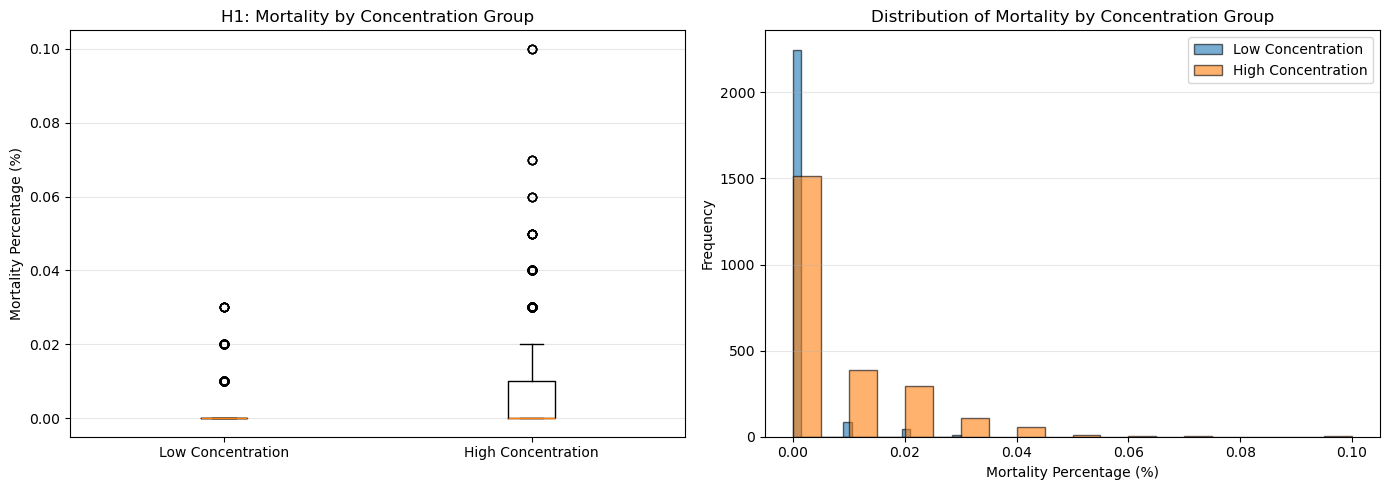

In [15]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot([low_conc, high_conc], labels=['Low Concentration', 'High Concentration'])
axes[0].set_ylabel('Mortality Percentage (%)')
axes[0].set_title('H1: Mortality by Concentration Group')
axes[0].grid(axis='y', alpha=0.3)

# Distribution plot
axes[1].hist(low_conc, bins=20, alpha=0.6, label='Low Concentration', edgecolor='black')
axes[1].hist(high_conc, bins=20, alpha=0.6, label='High Concentration', edgecolor='black')
axes[1].set_xlabel('Mortality Percentage (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Mortality by Concentration Group')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('hypothesis1_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# ============================================================================
# HYPOTHESIS 2: DISEASE-SPECIFIC CONCENTRATION-MORTALITY RELATIONSHIP
# ============================================================================

print("\n" + "=" * 80)
print("HYPOTHESIS 2: DISEASE-SPECIFIC CONCENTRATION-MORTALITY RELATIONSHIP")
print("=" * 80)

print("\nH₀: Mean mortality is equal across all disease types (COVID-19, Influenza, RSV)")
print("H₁: At least one disease shows different mortality during high concentration")
print("\nTest: One-Way ANOVA")
print("α = 0.05")

# Filter to high concentration weeks only
high_conc_weeks = merged_df[merged_df['conc_group'] == 'High']

# Get mortality by disease
covid_mort = high_conc_weeks[high_conc_weeks['disease'] == 'COVID-19']['percent']
flu_mort = high_conc_weeks[high_conc_weeks['disease'] == 'Influenza']['percent']
rsv_mort = high_conc_weeks[high_conc_weeks['disease'] == 'RSV']['percent']

print(f"\nGroup Sizes (High Concentration Weeks Only):")
print(f"  COVID-19: n = {len(covid_mort)}")
print(f"  Influenza: n = {len(flu_mort)}")
print(f"  RSV: n = {len(rsv_mort)}")

print(f"\nDescriptive Statistics (High Concentration Weeks):")
print(f"  COVID-19   - Mean: {covid_mort.mean():.4f}% (SD: {covid_mort.std():.4f})")
print(f"  Influenza  - Mean: {flu_mort.mean():.4f}% (SD: {flu_mort.std():.4f})")
print(f"  RSV        - Mean: {rsv_mort.mean():.4f}% (SD: {rsv_mort.std():.4f})")


HYPOTHESIS 2: DISEASE-SPECIFIC CONCENTRATION-MORTALITY RELATIONSHIP

H₀: Mean mortality is equal across all disease types (COVID-19, Influenza, RSV)
H₁: At least one disease shows different mortality during high concentration

Test: One-Way ANOVA
α = 0.05

Group Sizes (High Concentration Weeks Only):
  COVID-19: n = 1300
  Influenza: n = 716
  RSV: n = 368

Descriptive Statistics (High Concentration Weeks):
  COVID-19   - Mean: 0.0109% (SD: 0.0137)
  Influenza  - Mean: 0.0033% (SD: 0.0067)
  RSV        - Mean: 0.0004% (SD: 0.0020)


In [17]:
# ---- ASSUMPTION CHECKING ----

print("\n--- ASSUMPTION VERIFICATION ---")

# 1. Normality per group
print("\n1. Normality Test (Shapiro-Wilk per group):")
groups = [covid_mort, flu_mort, rsv_mort]
group_names = ['COVID-19', 'Influenza', 'RSV']
normality_results = []
for group, name in zip(groups, group_names):
    if len(group) > 0:
        stat, p = shapiro(group)
        print(f"   {name}: p-value = {p:.4f}")
        normality_results.append(p > 0.05)
    else:
        print(f"   {name}: Insufficient data")
        normality_results.append(True)

# 2. Equal Variances (Levene's)
print("\n2. Equal Variances Test (Levene's):")
if all(len(g) > 0 for g in groups):
    stat_levene2, p_levene2 = levene(covid_mort, flu_mort, rsv_mort)
    print(f"   Statistic: {stat_levene2:.4f}, p-value: {p_levene2:.4f}")
    equal_var_met2 = p_levene2 > 0.05
    print(f"   Equal variance assumption {'MET' if equal_var_met2 else 'VIOLATED'}")

# ---- TEST EXECUTION ----

print("\n--- TEST EXECUTION ---")

f_stat, p_value2 = f_oneway(covid_mort, flu_mort, rsv_mort)

print(f"\nOne-Way ANOVA Results:")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value: {p_value2:.4f}")


--- ASSUMPTION VERIFICATION ---

1. Normality Test (Shapiro-Wilk per group):
   COVID-19: p-value = 0.0000
   Influenza: p-value = 0.0000
   RSV: p-value = 0.0000

2. Equal Variances Test (Levene's):
   Statistic: 321.9745, p-value: 0.0000
   Equal variance assumption VIOLATED

--- TEST EXECUTION ---

One-Way ANOVA Results:
  F-statistic: 193.7573
  p-value: 0.0000



--- STATISTICAL DECISION (α = 0.05) ---
✓ REJECT H₀ (p = 0.0000 < 0.05)
  Result: Disease-specific differences in mortality during high concentration


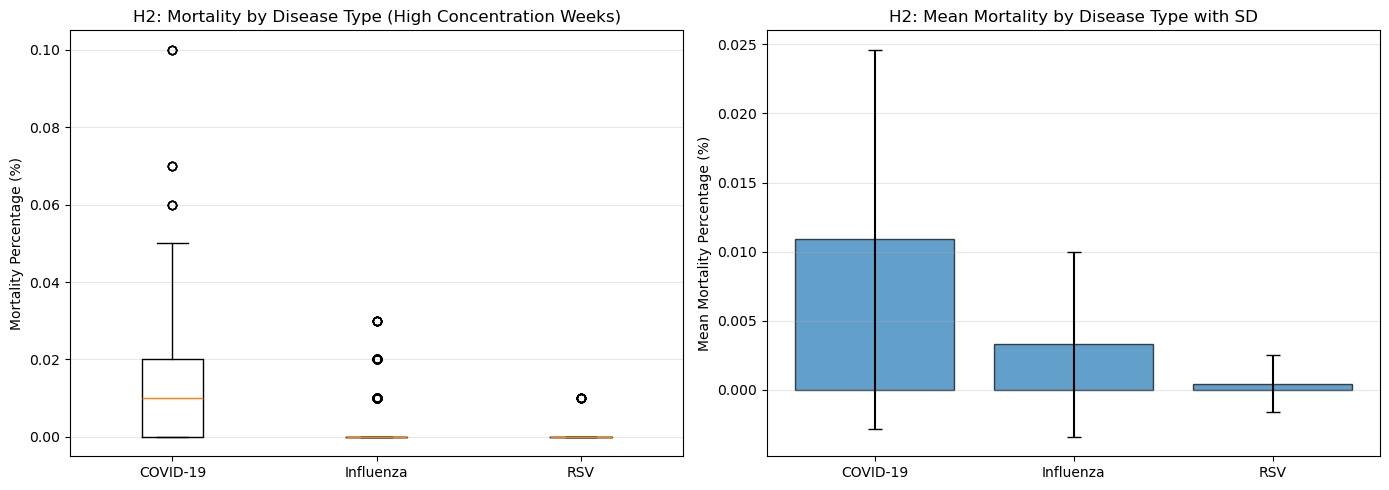

In [18]:
# ---- STATISTICAL DECISION ----

print(f"\n--- STATISTICAL DECISION (α = {alpha}) ---")
if p_value2 < alpha:
    print(f"✓ REJECT H₀ (p = {p_value2:.4f} < {alpha})")
    print(f"  Result: Disease-specific differences in mortality during high concentration")
else:
    print(f"✗ FAIL TO REJECT H₀ (p = {p_value2:.4f} ≥ {alpha})")
    print(f"  Result: No significant differences across diseases")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
disease_mort_data = [covid_mort, flu_mort, rsv_mort]
axes[0].boxplot(disease_mort_data, labels=['COVID-19', 'Influenza', 'RSV'])
axes[0].set_ylabel('Mortality Percentage (%)')
axes[0].set_title('H2: Mortality by Disease Type (High Concentration Weeks)')
axes[0].grid(axis='y', alpha=0.3)

# Bar plot with error bars
means = [covid_mort.mean(), flu_mort.mean(), rsv_mort.mean()]
stds = [covid_mort.std(), flu_mort.std(), rsv_mort.std()]
x_pos = np.arange(len(group_names))
axes[1].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(group_names)
axes[1].set_ylabel('Mean Mortality Percentage (%)')
axes[1].set_title('H2: Mean Mortality by Disease Type with SD')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('hypothesis2_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# ============================================================================
# HYPOTHESIS 3: ASSOCIATION BETWEEN CONCENTRATION AND MORTALITY SEVERITY
# ============================================================================

print("\n" + "=" * 80)
print("HYPOTHESIS 3: ASSOCIATION BETWEEN CONCENTRATION AND MORTALITY SEVERITY")
print("=" * 80)

print("\nH₀: Concentration level and mortality severity are independent")
print("H₁: Concentration level and mortality severity are associated")
print("\nTest: Chi-Squared Test of Independence")
print("α = 0.05")

# Create mortality severity categories
merged_df['mortality_severity'] = pd.cut(merged_df['percent'], 
                                          bins=[-0.1, 1, 3, 100],
                                          labels=['Low (≤1%)', 'Moderate (1-3%)', 'High (>3%)'])

# Create contingency table
contingency = pd.crosstab(merged_df['wkavg_val_category'], 
                          merged_df['mortality_severity'])

print(f"\nContingency Table:")
print(contingency)

# Check cell frequencies
print(f"\nCell Frequencies Check:")
print(f"  Minimum expected frequency: {contingency.values.min()}")
print(f"  All cells ≥ 5: {(contingency.values >= 5).all()}")

# ---- TEST EXECUTION ----

print("\n--- TEST EXECUTION ---")

chi2, p_value3, dof, expected = chi2_contingency(contingency)

print(f"\nChi-Squared Test Results:")
print(f"  Chi-squared statistic: {chi2:.4f}")
print(f"  p-value: {p_value3:.4f}")
print(f"  Degrees of freedom: {dof}")


HYPOTHESIS 3: ASSOCIATION BETWEEN CONCENTRATION AND MORTALITY SEVERITY

H₀: Concentration level and mortality severity are independent
H₁: Concentration level and mortality severity are associated

Test: Chi-Squared Test of Independence
α = 0.05

Contingency Table:
mortality_severity  Low (≤1%)
wkavg_val_category           
High                      316
Low                      1079
Minimal                  2384
Moderate                  607
Very High                 382

Cell Frequencies Check:
  Minimum expected frequency: 316
  All cells ≥ 5: True

--- TEST EXECUTION ---

Chi-Squared Test Results:
  Chi-squared statistic: 0.0000
  p-value: 1.0000
  Degrees of freedom: 0


  Cramér's V (effect size): 0.0000

--- STATISTICAL DECISION (α = 0.05) ---
✗ FAIL TO REJECT H₀ (p = 1.0000 ≥ 0.05)
  Result: No association between concentration and mortality severity


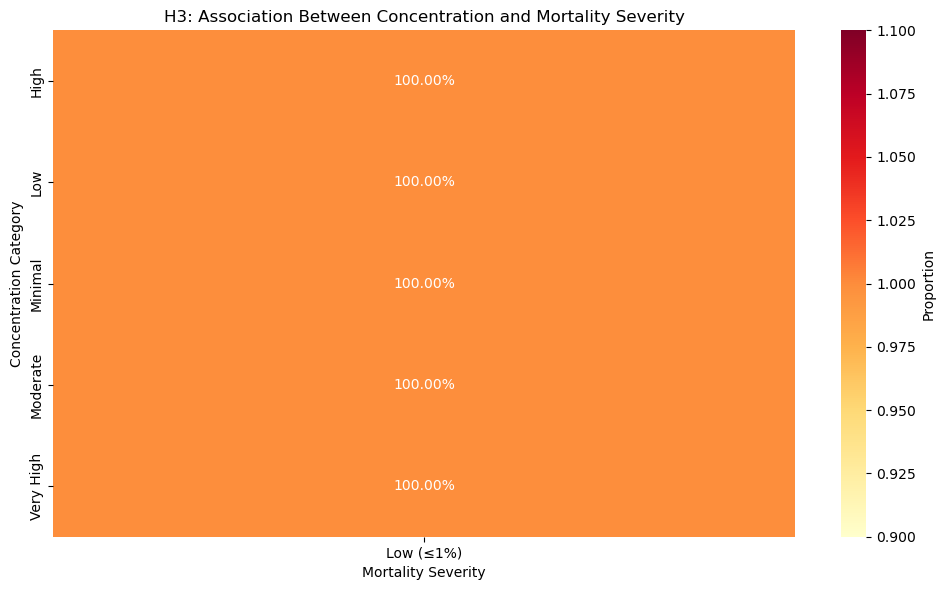

In [20]:
# Cramér's V (effect size for chi-squared)
n = contingency.values.sum()
min_dim = min(contingency.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
print(f"  Cramér's V (effect size): {cramers_v:.4f}")

# ---- STATISTICAL DECISION ----

print(f"\n--- STATISTICAL DECISION (α = {alpha}) ---")
if p_value3 < alpha:
    print(f"✓ REJECT H₀ (p = {p_value3:.4f} < {alpha})")
    print(f"  Result: Concentration severity and mortality severity are ASSOCIATED")
else:
    print(f"✗ FAIL TO REJECT H₀ (p = {p_value3:.4f} ≥ {alpha})")
    print(f"  Result: No association between concentration and mortality severity")

# Visualization (Heatmap)
fig, ax = plt.subplots(figsize=(10, 6))
normalized_contingency = contingency.div(contingency.sum(axis=1), axis=0)
sns.heatmap(normalized_contingency, annot=True, fmt='.2%', cmap='YlOrRd', 
            cbar_kws={'label': 'Proportion'}, ax=ax)
ax.set_xlabel('Mortality Severity')
ax.set_ylabel('Concentration Category')
ax.set_title('H3: Association Between Concentration and Mortality Severity')
plt.tight_layout()
plt.savefig('hypothesis3_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# ============================================================================
# SUMMARY REPORT
# ============================================================================

print("\n" + "=" * 80)
print("SUMMARY OF HYPOTHESIS TESTING RESULTS")
print("=" * 80)

results_summary = pd.DataFrame({
    'Hypothesis': [
        'H1: High conc → Higher mortality',
        'H2: Disease-specific differences',
        'H3: Concentration-Severity Association'
    ],
    'Test': ['t-test', 'ANOVA', 'Chi-Squared'],
    'Test Statistic': [f'{t_stat:.4f}', f'{f_stat:.4f}', f'{chi2:.4f}'],
    'p-value': [f'{p_value:.4f}', f'{p_value2:.4f}', f'{p_value3:.4f}'],
    'Result': [
        '✓ REJECT H₀' if p_value < alpha else '✗ FAIL TO REJECT',
        '✓ REJECT H₀' if p_value2 < alpha else '✗ FAIL TO REJECT',
        '✓ REJECT H₀' if p_value3 < alpha else '✗ FAIL TO REJECT'
    ]
})

print("\n")
print(results_summary.to_string(index=False))

print("\n" + "=" * 80)
print("Analysis complete. Visualizations saved as hypothesis[1-3]_results.png")
print("=" * 80)


SUMMARY OF HYPOTHESIS TESTING RESULTS


                            Hypothesis        Test Test Statistic p-value           Result
      H1: High conc → Higher mortality      t-test        24.6402  0.0000      ✓ REJECT H₀
      H2: Disease-specific differences       ANOVA       193.7573  0.0000      ✓ REJECT H₀
H3: Concentration-Severity Association Chi-Squared         0.0000  1.0000 ✗ FAIL TO REJECT

Analysis complete. Visualizations saved as hypothesis[1-3]_results.png
